<a href="https://colab.research.google.com/github/BrunoEMendes/Google_colab_NN/blob/master/MDSQP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimum Dominating Set of Queens Problem (MDSQP)

In [2]:
import numpy as np
from random import randint
import random

## Individual

In [3]:
class Individual:
  def __init__(self, n_queens = 2, pm = 0.05, board_shape = (8, 8), genome = None):
    self.n_queens = n_queens
    self.__board_shape = board_shape
    self.pm = pm
    self.__max_int = board_shape[0] * board_shape[1] - 1
    self.__length = self.__set_max_individual_length()
    if genome is not None:
      q = self.__set_genome(genome)
    else:
      q = self.__gen_queen_list()
    self.queens = q
    self.__fitness = self.__update_fitness()


  # private functions
  def __binary_to_decimal(self, num):
    '''
    converts from binary to decimal
    '''
    return int(num, 2) 

  
  def __helper_queen_size(self, queen):
    '''
    returns queen length
    '''
    return self.__length == len(queen) 
  
  def __set_genome(self, genome):

    '''
    checks if the genome is valid
    '''
    assert len(genome) == self.n_queens

    length_check = [self.__helper_queen_size(q) for q in genome]
    assert False not in length_check

    pop= []
    for g in genome:
      if self.__binary_to_decimal(g) >= self.__max_int:
        pop.append(self.__decimal_to_binary_fixed_len(0))
      else:
        pop.append(g)
    return pop

  def __flip(self, queen):
    '''
    
    '''
    tmp = list(queen)
    flip_pos = randint(0, len(queen) - 1)
    tmp[flip_pos] = '1' if tmp[flip_pos] == '0' else  '0'
    flip_pos_2 = randint(0, len(queen) - 1)
    while(flip_pos_2  == flip_pos):
      flip_pos_2 = randint(0, len(queen) - 1)
    return ''.join(tmp)

  def mutate(self):
    for i in range(0, len(self.queens)):
      if random.random() < self.pm:
        tmp = self.__flip(self.queens[i])
        while(self.__binary_to_decimal(tmp) > self.__max_int):
          tmp = self.__flip(self.queens[i])
        self.queens[i] = tmp        


  def __decimal_to_binary_fixed_len(self, num): 
    '''
    converts from decimal to binary with a fixed length
    '''
    return f'{num:0{self.__length}b}'

  def __decimal_to_binary(self, num):
    '''
    converts from decimal to binary
    '''
    return bin(num)[2:]

  def __set_max_individual_length(self):
    '''
    sets the individual length based on the board shape
    '''
    return len(self.__decimal_to_binary(self.__max_int))

  def __gen_queen_list(self):
    '''
    gens the set of queens
    '''
    return [self.__decimal_to_binary_fixed_len(randint(0, self.__max_int)) for i in range(self.n_queens)]

  def __get_queen_x_y(self, queen):
    x = int(queen / self.__board_shape[0])
    y = int(queen - x * self.__board_shape[0])
    return x, y


  def __get_dominated_pos_vertical(self, x):
    '''
    returns the verticals being dominated by the queen
    '''
    return [(x * self.__board_shape[0] + y) for y in range(0, self.__board_shape[1])]
  
  def __get_dominated_pos_horizontal(self, y):
    '''
    return the horizontals being dominated by the queen
    '''
    return [(x * self.__board_shape[0] + y) for x in range(0, self.__board_shape[1])]

  #https://stackoverflow.com/questions/6313308/get-all-the-diagonals-in-a-matrix-list-of-lists-in-python
  def __get_dominated_pos_diagonal(self, queen):
    '''
    returns the diagonals being dominated by the queens
    '''
    x, y = self.__board_shape
    a = np.arange(x*y).reshape(x,y)

    diags = [a[::-1,:].diagonal(i) for i in range(-a.shape[0]+1,a.shape[1])]
    diags.extend(a.diagonal(i) for i in range(a.shape[1]-1,-a.shape[0],-1))
    return [d.tolist() for d in diags if queen in d.tolist()]
  
  # fitness is defined by the ammount of covered board by the queens
  def __update_fitness(self):
    '''
    Updates the fitness of the individual
    '''
    dominated_pos = []
    for q in self.queens:

      queen = self.__binary_to_decimal(q)
      x, y  = self.__get_queen_x_y(queen)
      diagonals = self.__get_dominated_pos_diagonal(queen)
      for diag in diagonals:
        dominated_pos = dominated_pos + diag 
      dominated_pos = dominated_pos + self.__get_dominated_pos_vertical(x) + self.__get_dominated_pos_horizontal(y)
    res = list(set(dominated_pos))
    return len(res) / (self.__max_int + 1)

  #public functions
  
  def get_n_queens(self):
    '''
    return number of queens
    '''
    return self.n_queens

  def get_queens(self):
    return self.queens
  
  def fitness(self):
    return self.__fitness

  def describe(self):
    '''
    returns full description of the individual
    '''
    return f'''Description of Individual 
Number of Queens: {self.n_queens}
Queens Length: {self.__length}
Queens: {self.queens}
Fitness: {self.__fitness}
Board Shape:  {self.__board_shape}
PM: {self.pm}
'''


### Tests

In [4]:
n_queens = 2
pm = 0.05
board_shape = (10, 10)

In [5]:
ind = Individual(n_queens, 1, board_shape)
print(ind.describe())
print(ind.mutate())
print(ind.describe())

Description of Individual 
Number of Queens: 2
Queens Length: 7
Queens: ['0011110', '0111011']
Fitness: 0.52
Board Shape:  (10, 10)
PM: 1

None
Description of Individual 
Number of Queens: 2
Queens Length: 7
Queens: ['0001110', '0110011']
Fitness: 0.52
Board Shape:  (10, 10)
PM: 1



In [6]:
ind2 = Individual(n_queens, pm, board_shape, genome = ['0101100', '1110100'])
print(ind2.describe())

Description of Individual 
Number of Queens: 2
Queens Length: 7
Queens: ['0101100', '0000000']
Fitness: 0.5
Board Shape:  (10, 10)
PM: 0.05



## Population

In [17]:
from operator import attrgetter

class Population:
  def __init__(self, pop_size, n_queens = 2,  board_shape = (8, 8), pc = 0.5, pm = 0.05):
    self.__pop_size = pop_size
    self.__board_shape = board_shape
    self.__n_queens = n_queens
    self.pc = pc
    self.pm = pm
    self.population = self.__gen_pop_list()

  
  #private
  def __gen_pop_list(self):
    return [Individual(n_queens = self.__n_queens, pm = self.pm, board_shape = self.__board_shape) for i in range(0, self.__pop_size)]

  # rolette wheel selection
  def __rws(self, pointers):
    keep = []
    for p in pointers:
      i = 0
      sum_i = self.population[0].fitness()
      while sum_i < p:
          i = i + 1
          sum_i = sum_i + self.population[i].fitness()
      keep.append(self.population[i])
    return keep
  

  def __str__(self):
    return f'''Population info
Max Fitness: {self.max_fitness()}
Min Fitness: {self.min_fitness()} 
Mean Fitness: {self.mean_fitness()}   
'''

  #public
  def get_population(self):
    return self.population

  def mean_fitness(self):
    return self.total_fitness() / len(self.population)

  def max_fitness(self):
    return np.max([p.fitness() for p in self.population])

  def min_fitness(self):
    return np.min([float(p.fitness()) for p in self.population])

  def total_fitness(self):
    return sum(p.fitness() for p in self.population)


  def selection(self, cutoff = 0.5):
    self.population.sort(key=lambda x: x.fitness(), reverse=True)
    #self.population = [x for x in self.population if x.fitness() >= cutoff]
    self.population = self.population[:int(len(self.population) / 2)]

    size = self.__pop_size
    f = self.total_fitness()
    
    p =  f / size
    start = random.uniform(0, p)
    pointers = [start + i * p for i in range(size)]
    self.population = self.__rws(pointers)




  def crossover(self, crossover_alg = 'single_point_crossover'):
    random.shuffle(self.population)
    if crossover_alg == 'single_point_crossover':
      self.__single_point_crossover()

  def mutate(self):
    [i.mutate() for i in self.population]

  def get_population(self):
    return self.population

  
  def __single_point_crossover(self):
    pop = []
    for i in range(0, len(self.population), 2):
      if i + 1 == len(self.population):
        pop.append(self.population[i])
        break
      parent1 = self.population[i].get_queens()
      parent2 = self.population[i + 1].get_queens()
      child1 = []
      child2 = []
      for j in range(0, len(parent1)):
        if random.random() < self.pc:
          cross_pos = randint(1, len(parent1[j]) - 1)
          child1.append(parent1[j][:cross_pos] + parent2[j][cross_pos:])
          child2.append(parent2[j][:cross_pos] + parent1[j][cross_pos:])
        else:
          child1.append(parent1[j])
          child2.append(parent2[j])
      pop.append(Individual(n_queens=self.__n_queens, pm = self.pm, board_shape = self.__board_shape, genome = child1))
      pop.append(Individual(n_queens=self.__n_queens, pm = self.pm, board_shape = self.__board_shape, genome = child2))

    self.population = pop
  
  def describe(self):
    return f'''Population Description
Size: {self.__pop_size}
Board Shape: {self.__board_shape}
Number of queens: {self.__n_queens}
PC: {self.pc}
PM: {self.pm}
'''



### TEST

In [16]:
p = Population(pop_size = 100, n_queens= 3, pc = 0.5,  pm=0.05, board_shape=(10, 8))
print(p.describe())
print(p)

for i in range(0, 1):
  p.selection()
  p.crossover()
  p.mutate()
  print(p)



Population Description
Size: 100
Board Shape: (10, 8)
Number of queens: 3
PC: 0.5
PM: 0.05

Population info
Max Fitness: 0.7875
Min Fitness: 0.5125 
Mean Fitness: 0.6613749999999999   

Population info
Max Fitness: 0.7875
Min Fitness: 0.6625 
Mean Fitness: 0.7080000000000001   



## Gentic Algorithm

In [37]:
class GA:
  def __init__(self, pop_size, n_queens = 3, pc = 0.5, pm = 0.05, board_shape = (10, 8)):
    self.__n_queens = n_queens
    self.__pop_size = pop_size
    self.pc = pc
    self.pm = pm
    self.__board_shape = board_shape
    self.population = Population(pop_size=self.__pop_size, n_queens=self.__n_queens, board_shape = self.__board_shape, pc = self.pc, pm = self.pm)
    print(self.population.describe())

  def fit(self, epochs, verbose = 1):
    max = [self.population.max_fitness()]
    min = [self.population.min_fitness()]
    mean  = [self.population.mean_fitness()]
    for i in range(0, epochs):
      self.population.selection()
      self.population.crossover()
      self.population.mutate()
      if verbose == 1:
        print(p)
      max.append(self.population.max_fitness())
      min.append(self.population.min_fitness())
      mean.append(self.population.mean_fitness())
    return max, min, mean



### Results

In [110]:
ga = GA(pop_size = 100, n_queens= 5, pc = 1, pm = 0.05, board_shape = (8, 8))
max, min, mean = ga.fit(epochs=400, verbose = 0)


Population Description
Size: 100
Board Shape: (8, 8)
Number of queens: 5
PC: 1
PM: 0.05



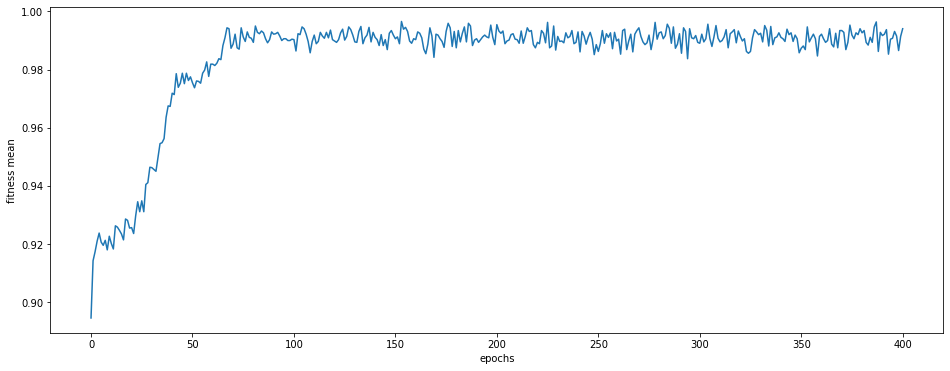

In [111]:
import matplotlib.pyplot as plt
plt.figure(1, figsize =(16, 6))
plt.plot(mean)
plt.xlabel('epochs')
plt.ylabel('fitness mean')
plt.show()

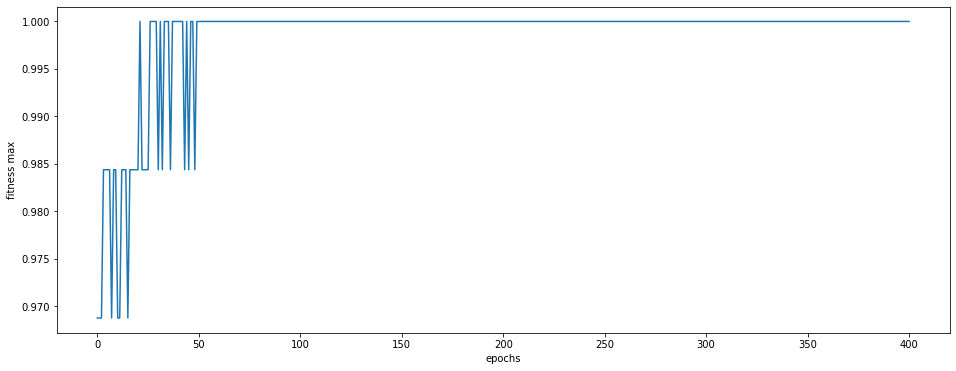

In [112]:
plt.figure(1, figsize =(16, 6))
plt.plot(max)
plt.xlabel('epochs')
plt.ylabel('fitness max')
plt.show()

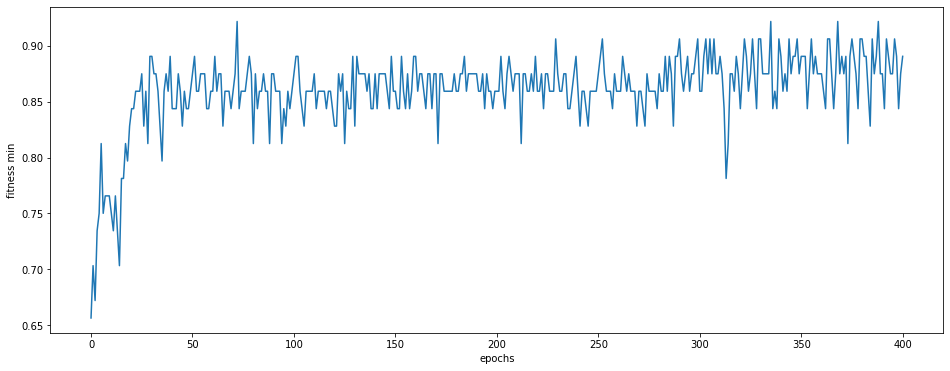

In [107]:
plt.figure(1, figsize =(16, 6))
plt.plot(min)
plt.xlabel('epochs')
plt.ylabel('fitness min')
plt.show()

In [113]:
print(min[-1], mean[-1], max[-1])

0.921875 0.9940625 1.0
